<a href="https://colab.research.google.com/github/arunmadhusud/pointnet/blob/main/pointnet_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
# install open3d
!pip install open3d

In [ ]:
# Download ShapeNet Dataset
!wget -nv https://shapenet.cs.stanford.edu/ericyi/shapenetcore_partanno_segmentation_benchmark_v0.zip --no-check-certificate

  Issued certificate has expired.
2024-07-15 19:08:51 URL:https://shapenet.cs.stanford.edu/ericyi/shapenetcore_partanno_segmentation_benchmark_v0.zip [666265910/666265910] -> "shapenetcore_partanno_segmentation_benchmark_v0.zip" [1]


In [ ]:
# Unzip Datataset
!unzip shapenetcore_partanno_segmentation_benchmark_v0.zip

# Model


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:

class Tnet(nn.Module):
    def __init__(self, k, num_points = 2500):
        super(Tnet, self).__init__()

        self.dim = k

        # Define convolutional layers
        self.conv1 = nn.Conv1d(k, 64, kernel_size=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=1)
        self.conv3 = nn.Conv1d(128, 1024, kernel_size=1)

        # Define linear layers
        self.linear1 = nn.Linear(1024, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, k * k)

        # Define batch normalization layers
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

        # Define max pooling layer
        self.max_pool = nn.MaxPool1d(kernel_size=num_points)

    def forward(self, x):
        bs = x.shape[0]  # Batch size

        # Apply first convolution, batch norm, and ReLU activation
        x = F.relu(self.bn1(self.conv1(x)))
        # Apply second convolution, batch norm, and ReLU activation
        x = F.relu(self.bn2(self.conv2(x)))
        # Apply third convolution, batch norm, and ReLU activation
        x = F.relu(self.bn3(self.conv3(x)))

        # Apply max pooling
        x = self.max_pool(x)
        # Flatten the output
        x = x.view(bs, -1)

        # Apply first linear layer, batch norm, and ReLU activation
        x = F.relu(self.bn4(self.linear1(x)))
        # Apply second linear layer, batch norm, and ReLU activation
        x = F.relu(self.bn5(self.linear2(x)))
        # Apply third linear layer to get the transformation matrix
        x = self.linear3(x)

        # Create an identity matrix of size k*k
        i_mat = torch.eye(self.dim, requires_grad=True).repeat(bs, 1, 1)

        # Move the identity matrix to GPU if the input is on GPU
        if x.is_cuda:
            i_mat = i_mat.cuda()

        # Reshape the output to a batch of k*k matrices and add the identity matrix
        x = x.view(-1, self.dim, self.dim) + i_mat

        return x


#function to test the Tnet
def test_tnet(k, batch_size, num_points):
    # Create an instance of Tnet
    tnet = Tnet(k,num_points)

    # Create a dummy input
    # Shape: [batch_size, k, num_points]
    dummy_input = torch.randn(batch_size, k, num_points)

    # Pass the dummy input through the Tnet
    output = tnet(dummy_input)

    # Print shapes
    print(f"Input shape: {dummy_input.shape}")
    print(f"Output shape: {output.shape}")

    # Check if the output is a batch of k*k matrices
    assert output.shape == (batch_size, k, k), f"Expected output shape {(batch_size, k, k)}, but got {output.shape}"

    print("Tnet test passed successfully!")

    # Optionally, print a sample output matrix
    print("\nSample output matrix:")
    print(output[0])  # Print the first matrix in the batch

# Run the test
if __name__ == "__main__":
    k = 3  # Dimension of input features
    batch_size = 32
    num_points = 2500

    test_tnet(k, batch_size, num_points)






Input shape: torch.Size([32, 3, 2500])
Output shape: torch.Size([32, 3, 3])
Tnet test passed successfully!

Sample output matrix:
tensor([[ 0.5255,  0.3057, -0.2582],
        [-0.1083,  0.3084,  0.0738],
        [-0.2267,  0.0639,  1.8286]], grad_fn=<SelectBackward0>)


In [ ]:
class PointNet(nn.Module):
    """
    PointNet class processes 3D point cloud data to extract local and global features.
    It uses two Tnet layers for affine transformations and several convolutional layers
    to extract features from the input point cloud. Depending on the 'local_ftr' flag,
    it can return a combination of local and global features (needed for segmentation) or just the global features(needed for classification).
    """
    def __init__(self, num_points=2500, num_global_ftrs=1024, local_ftr=True):
        super(PointNet, self).__init__()
        self.num_points = num_points
        self.num_global_ftrs = num_global_ftrs
        self.local_ftr = local_ftr

        # Transformation networks for input and feature space
        self.tnet1 = Tnet(k=3, num_points=num_points)
        self.tnet2 = Tnet(k=64, num_points=num_points)

        # Convolutional layers
        self.conv1 = nn.Conv1d(3, 64, kernel_size=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=1)
        self.conv3 = nn.Conv1d(64, 64, kernel_size=1)
        self.conv4 = nn.Conv1d(64, 128, kernel_size=1)
        self.conv5 = nn.Conv1d(128, num_global_ftrs, kernel_size=1)

        # Batch normalization layers
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(64)
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(num_global_ftrs)

        # Max pooling layer
        self.max_pool = nn.MaxPool1d(kernel_size=num_points, return_indices=True)

    def forward(self, x):
        bs = x.shape[0]  # Batch size

        # Apply first transformation network
        t_matrix1 = self.tnet1(x)
        x = torch.bmm(x.transpose(2, 1), t_matrix1).transpose(2, 1)

        # First two convolutional layers with ReLU activation and batch normalization
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))

        # Apply second transformation network
        t_matrix2 = self.tnet2(x)
        x = torch.bmm(x.transpose(2, 1), t_matrix2).transpose(2, 1)

        # Clone the local features for later use
        local_features = x.clone()

        # Further convolutional layers
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))

        # Max pooling to obtain global features
        global_features, global_indexes = self.max_pool(x)
        global_features = global_features.view(bs, -1)
        global_indexes = global_indexes.view(bs, -1)

        if self.local_ftr:
            # Concatenate local and global features if local_ftr is True
            features = torch.cat((local_features, global_features.unsqueeze(-1).repeat(1, 1, self.num_points)), dim=1)
            return features, global_indexes, t_matrix1, t_matrix2
        else:
            # Return only global features, global indexes, and second transformation matrix
            return global_features, global_indexes, t_matrix1, t_matrix2

# Create a dummy input tensor
dummy_input = torch.rand(32, 3, 2500)  # Batch size of 32, 3 coordinates, 2500 points

# Instantiate the PointNet model
model = PointNet()

# Perform a forward pass with the dummy input
output = model(dummy_input)

# Print the output shapes
for out in output:
    print(out.shape)


torch.Size([32, 1088, 2500])
torch.Size([32, 1024])
torch.Size([32, 3, 3])
torch.Size([32, 64, 64])


In [ ]:
class PointNetClas(nn.Module):
    """
    PointNetClas class is designed for classification tasks using 3D point cloud data.
    It extends the PointNet class to include fully connected layers for classification
    and uses dropout for regularization.
    """
    def __init__(self, num_points=2500, num_global_ftrs=1024, num_classes=2):
        super(PointNetClas, self).__init__()

        # Initialize the PointNet network without local features
        self.network = PointNet(num_points=num_points, num_global_ftrs=num_global_ftrs, local_ftr=False)

        # Fully connected layers for classification
        self.linear1 = nn.Linear(num_global_ftrs, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, num_classes)  # Change 'k' to 'num_classes'

        # Batch normalization layers
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        # Extract features using PointNet
        features, idxs, input_transform, feat_transform = self.network(x)

        # Apply fully connected layers with ReLU activation and batch normalization
        x = F.relu(self.bn1(self.linear1(features)))
        x = F.relu(self.bn2(self.linear2(x)))

        # Apply dropout for regularization
        x = self.dropout(x)

        # Output layer
        x = self.linear3(x)

        # Return features, indices from max pool, and feature transformation matrix
        return x, idxs, input_transform, feat_transform



# Dummy data
batch_size = 8
num_points = 2500
input_dim = 3
num_classes = 2

# Generate random input data
dummy_input = torch.rand(batch_size, input_dim, num_points)

# Instantiate the model
model = PointNetClas(num_points=num_points, num_global_ftrs=1024, num_classes=num_classes)

# Forward pass with the dummy data
output, idxs,input_transform, feat_transform = model(dummy_input)

# Print the outputs
print("Output shape:", output.shape)  # Expected shape: (batch_size, num_classes)
print("Indices shape:", idxs.shape)  # Expected shape: (batch_size, 1)
print("Feature transformation matrix shape:", feat_transform.shape)  # Expected shape: (batch_size, 64, 64)

# Check the model output
print("Output:", output)

Output shape: torch.Size([8, 2])
Indices shape: torch.Size([8, 1024])
Feature transformation matrix shape: torch.Size([8, 64, 64])
Output: tensor([[-0.1707, -0.2439],
        [-0.1170,  0.3424],
        [-0.5784, -0.1329],
        [ 0.4125, -0.1626],
        [ 0.2673, -0.5199],
        [ 0.2326, -0.9663],
        [-0.5366,  0.0456],
        [ 0.5780, -0.6498]], grad_fn=<AddmmBackward0>)


In [ ]:
class PointNetSeg(nn.Module):
    """
    PointNetSeg class is designed for segmentation tasks using 3D point cloud data.
    It extends the PointNet class to include shared MLP layers for per-point classification.
    """
    def __init__(self, num_points=2500, num_global_ftrs=1024, num_classes=2):
        super(PointNetSeg, self).__init__()

        # Initialize the PointNet network with local features
        self.network = PointNet(num_points=num_points, num_global_ftrs=num_global_ftrs, local_ftr=True)

        # Shared MLP layers for segmentation
        num_features = num_global_ftrs + 64  # local and global features
        self.conv1 = nn.Conv1d(num_features, 512, kernel_size=1)
        self.conv2 = nn.Conv1d(512, 256, kernel_size=1)
        self.conv3 = nn.Conv1d(256, 128, kernel_size=1)
        self.conv4 = nn.Conv1d(128, num_classes, kernel_size=1)

        # Batch normalization layers for shared MLP
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)

    def forward(self, x):
        # Extract features using PointNet
        features, idxs,input_transform, feat_transform = self.network(x)

        # Apply shared MLP layers with ReLU activation and batch normalization
        x = F.relu(self.bn1(self.conv1(features)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))

        # Output layer for per-point classification
        x = self.conv4(x)

        # Transpose the output to match the expected shape
        x = x.transpose(2, 1)

        # Return the per-point scores, indices from max pool, and feature transformation matrix
        return x, idxs,input_transform, feat_transform

# Dummy code to test the PointNetSeg class
batch_size = 8
num_points = 2500
input_dim = 3
num_classes = 2

# Generate random input data
dummy_input = torch.rand(batch_size, input_dim, num_points)

# Instantiate the model
model = PointNetSeg(num_points=num_points, num_global_ftrs=1024, num_classes=num_classes)

# Forward pass with the dummy data
output, idxs,input_transform, feat_transform = model(dummy_input)

# Print the outputs
print("Output shape:", output.shape)  # Expected shape: (batch_size, num_points, num_classes)
print("Indices shape:", idxs.shape)  # Expected shape: (batch_size, 1)
print("Feature transformation matrix shape:", feat_transform.shape)  # Expected shape: (batch_size, 64, 64)







Output shape: torch.Size([8, 2500, 2])
Indices shape: torch.Size([8, 1024])
Feature transformation matrix shape: torch.Size([8, 64, 64])


# Dataset

In [ ]:
import os
import json
import numpy as np
import open3d as o3
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

class ShapenetDataset(Dataset):

    def __init__(self, root, split, npoints=2500, classification=False, class_choice=None,
                 image=False, normalize=True):

        self.root = root
        self.split = split.lower()
        self.npoints = npoints
        self.catfile = os.path.join(self.root, 'synsetoffset2category.txt')
        self.cat = {} # dictionary to map folders to classes
        self.classification = classification
        self.image = image
        self.normalize = normalize

        # Open the Category File and Map Folders to Categories
        with open(self.catfile, 'r') as f:
            for line in f:
                ls = line.strip().split()
                self.cat[ls[0]] = ls[1]

        # select specific categories from the dataset.
        # ex: Call in parameters "class_choice=["Airplane"].
        if not class_choice is  None:
            self.cat = {k:v for k,v in self.cat.items() if k in class_choice}

        # for each category, assign the point, segmentation, and image.
        self.meta = {}
        for item in self.cat:
            self.meta[item] = []
            dir_point = os.path.join(self.root, self.cat[item], 'points')
            dir_seg = os.path.join(self.root, self.cat[item], 'points_label')
            dir_seg_img = os.path.join(self.root, self.cat[item], 'seg_img')

            # get train, valid, test splits from json files
            if self.split == 'train':
                split_file = os.path.join(self.root,
                    'train_test_split', 'shuffled_train_file_list.json')
            elif self.split == 'test':
                split_file = os.path.join(self.root,
                    'train_test_split', 'shuffled_test_file_list.json')
            elif (self.split == 'valid') or (self.split == 'val'):
                split_file = os.path.join(self.root,
                    'train_test_split', 'shuffled_val_file_list.json')

            with open(split_file, 'r') as f:
                split_data = json.load(f)

            # print(split_data)

            # get point cloud file (.pts) names for current split
            pts_names = []
            for token in split_data:
                # print(token)
                if self.cat[item] in token:
                    pts_names.append(token.split('/')[-1] + '.pts')


            # FOR EVERY POINT CLOUD FILE
            for fn in pts_names:
                # print(fn)
                token = (os.path.splitext(os.path.basename(fn))[0])
                # print(token)
                # add point cloud, segmentations, and image to class metadata dict
                self.meta[item].append((os.path.join(dir_point, token + '.pts'),
                                        os.path.join(dir_seg, token + '.seg'),
                                        os.path.join(dir_seg_img, token + '.png')))

        # create list containing (item, points, segmentation points, segmentation image)
        self.datapath = []
        for item in self.cat:
            for fn in self.meta[item]:
                self.datapath.append((item, fn[0], fn[1], fn[2]))
        self.classes = dict(zip(sorted(self.cat), range(len(self.cat))))

        self.num_seg_classes = 0
        if not self.classification: # Take the Segmentation Labels
            for i in range(len(self.datapath)//50):
                # get number of seg classes in current item
                l = len(np.unique(np.loadtxt(self.datapath[i][2]).astype(np.uint8)))
                if l > self.num_seg_classes:
                    self.num_seg_classes = l

    def __getitem__(self, index):
            '''
            Each element has the format "class, points, segmentation labels, segmentation image"
            '''
            # Get one Element
            fn = self.datapath[index]

            # get its Class
            cls_ = self.classes[fn[0]]

            # Read the Point Cloud
            point_set = np.asarray(o3.io.read_point_cloud(fn[1], format='xyz').points,dtype=np.float32)

            # Read the Segmentation Data
            seg = np.loadtxt(fn[2]).astype(np.int64)

            # Read the Segmentation Image
            image = Image.open(fn[3])

            # down sample the pont cloud
            if len(seg) > self.npoints:
                choice = np.random.choice(len(seg), self.npoints, replace=False)
            else:
                # case when there are less points than the desired number
                choice = np.random.choice(len(seg), self.npoints, replace=True)

            point_set = point_set[choice, :]
            seg = seg[choice]
            point_set = torch.from_numpy(point_set)
            seg = torch.from_numpy(seg)
            cls_ = torch.from_numpy(np.array([cls_]).astype(np.int64))

            # add Gaussian noise to point set if not testing
            if self.split != 'test':
                # add N(0, 1/100) noise
                point_set += torch.randn(point_set.shape)/100

                # add random rotation to the point cloud
                point_set = self.random_rotate(point_set)

            # Normalize Point Cloud to (0, 1)
            if self.normalize:
                point_set = self.normalize_points(point_set)

            if self.classification:
                if self.image:
                    return point_set, cls_, image
                else:
                    return point_set, cls_

            else:
                if self.image:
                    return point_set, seg, image
                else:
                    return point_set, seg


    @staticmethod
    def random_rotate(points):
        ''' randomly rotates point cloud about vertical axis.
            Code is commented out to rotate about all axes
            '''
        # construct a randomly parameterized 3x3 rotation matrix
        theta = torch.FloatTensor(1).uniform_(-torch.pi, torch.pi)

        rot_y = torch.Tensor([
            [torch.cos(theta),  0, torch.sin(theta)],
            [0,                 1,                0],
            [-torch.sin(theta), 0, torch.cos(theta)]])

        return torch.matmul(points, rot_y)

    @staticmethod
    def normalize_points(points):
        ''' Perform min/max normalization on points
            Same as:
            (x - min(x))/(max(x) - min(x))
            '''
        points = points - points.min(axis=0)[0]
        points /= points.max(axis=0)[0]

        return points


    def __len__(self):
        return len(self.datapath)




# Initialize the ShapenetDataset class
dataset = ShapenetDataset(root='/content/shapenetcore_partanno_segmentation_benchmark_v0', split='train',classification=True)

# Print some information to understand the data structure
print(f"Number of data points: {len(dataset.datapath)}")
print(f"Classes: {dataset.classes}")
print(f"Number of segmentation classes: {dataset.num_seg_classes}")
print(f"First data point: {dataset.datapath[0]}")

# Get a sample from the dataset
index = 0  # Example index
sample = dataset[index]

# print(sample[0].shape)

# # Print some information
print(f"Class label: {sample[1]}")  # Class label
print(f"Point cloud shape: {sample[0].shape}")  # Point cloud shape

# If images are included in the dataset
if dataset.image:
    image_tensor = ToTensor()(sample[3])  # Convert image to tensor
    print(f"Segmentation image shape: {image_tensor.shape}")  # Segmentation image shape

Number of data points: 12137
Classes: {'Airplane': 0, 'Bag': 1, 'Cap': 2, 'Car': 3, 'Chair': 4, 'Earphone': 5, 'Guitar': 6, 'Knife': 7, 'Lamp': 8, 'Laptop': 9, 'Motorbike': 10, 'Mug': 11, 'Pistol': 12, 'Rocket': 13, 'Skateboard': 14, 'Table': 15}
Number of segmentation classes: 0
First data point: ('Airplane', '/content/shapenetcore_partanno_segmentation_benchmark_v0/02691156/points/ed73e946a138f3cfbc0909d98a1ff2b4.pts', '/content/shapenetcore_partanno_segmentation_benchmark_v0/02691156/points_label/ed73e946a138f3cfbc0909d98a1ff2b4.seg', '/content/shapenetcore_partanno_segmentation_benchmark_v0/02691156/seg_img/ed73e946a138f3cfbc0909d98a1ff2b4.png')
Class label: tensor([0])
Point cloud shape: torch.Size([2500, 3])


In [ ]:
from torch.utils.data import DataLoader

root = '/content/shapenetcore_partanno_segmentation_benchmark_v0'
train_dataset = ShapenetDataset(root, split = 'train', npoints = 2500, classification= True)
train_dataloader = DataLoader(train_dataset,batch_size=32,shuffle=True)

test_dataset = ShapenetDataset(root,split = 'test', npoints=10000, classification= True)
test_dataloader = DataLoader(test_dataset,batch_size=32)

valid_dataset = ShapenetDataset(root,split='valid',npoints=2500,classification=True)
valid_dataloader = DataLoader(valid_dataset,batch_size=32)

In [ ]:
print("length of train_dataset: ", len(train_dataset))
print("length of test_dataset: ",  len(test_dataset))
print("length of valid_dataset: ", len(valid_dataset))

length of train_dataset:  12137
length of test_dataset:  2874
length of valid_dataset:  1870


# Loss

In [ ]:
import torch

def pointnetloss(outputs, labels, m3x3, m64x64, alpha=0.0001):
    """
    Compute the loss for PointNet.

    Parameters:
    - criterion: The loss function (e.g., CrossEntropyLoss for classification).
    - outputs: The model predictions.
    - labels: The ground truth labels.
    - m3x3: The 3x3 transformation matrix predicted by T-Net.
    - m64x64: The 64x64 transformation matrix predicted by T-Net.
    - alpha: The weight for the regularization term.

    Returns:
    - The total loss combining the criterion loss and the regularization loss.
    """
    bs = outputs.size(0)  # Batch size
    criterion = nn.CrossEntropyLoss()

    # Create identity matrices for regularization
    id3x3 = torch.eye(3).repeat(bs, 1, 1)
    id64x64 = torch.eye(64).repeat(bs, 1, 1)

    # Move identity matrices to the same device as outputs
    if outputs.is_cuda:
        id3x3 = id3x3.cuda()
        id64x64 = id64x64.cuda()

    # Compute the difference between the identity matrix and the product of the transformation matrix with its transpose
    diff3x3 = id3x3 - torch.bmm(m3x3, m3x3.transpose(1, 2))
    diff64x64 = id64x64 - torch.bmm(m64x64, m64x64.transpose(1, 2))

    # Calculate the regularization loss
    reg_loss = (torch.norm(diff3x3) + torch.norm(diff64x64)) / float(bs)

    # Calculate the total loss
    total_loss = criterion(outputs, labels) + alpha * reg_loss

    return total_loss


# Training

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [ ]:
import torch.optim as optim

classifier = PointNetClas(num_global_ftrs=1024, num_classes=16).to(DEVICE)
optimizer = optim.Adam(classifier.parameters(), lr=0.0001)



In [ ]:
def train(classifier,dataloader,epoch):
    loss_vals = []
    accuracy = []

    for i,(points,targets) in enumerate(dataloader,0):
        points = points.transpose(2,1).to(DEVICE)
        targets = targets.squeeze().to(DEVICE)

        # print(points.shape)
        # zero gradients
        optimizer.zero_grad()

        preds,_, input_transform, feat_transform = classifier(points)

        loss = pointnetloss(preds,targets,input_transform,feat_transform)

        loss.backward()

        optimizer.step()

        predicted_class = torch.softmax(preds,dim=1).argmax(dim=1)

        correct = (predicted_class == targets).float().sum()

        accuracy.append(correct/len(targets))

        loss_vals.append(loss.item())

        if i % 50 == 0:
            print(f"Epoch {epoch}, Batch {i}, Loss: {loss.item()}, Accuracy: {correct/len(targets)}")


    # Calculate mean loss and accuracy
    mean_loss = torch.tensor(loss_vals).mean().item()
    mean_accuracy = torch.tensor(accuracy).mean().item()

    return mean_loss, mean_accuracy





In [ ]:
def validate(classifier,dataloader,epoch):
    loss_vals = []
    accuracy = []

    for i,(points,targets) in enumerate(dataloader,0):
        points = points.transpose(2,1).to(DEVICE)
        targets = targets.squeeze().to(DEVICE)

        classifier.eval()
        with torch.no_grad():
            preds,_, input_transform, feat_transform = classifier(points)

        loss = pointnetloss(preds,targets,input_transform,feat_transform)

        predicted_class = torch.softmax(preds,dim=1).argmax(dim=1)

        correct = (predicted_class == targets).float().sum()

        accuracy.append(correct/len(targets))

        loss_vals.append(loss.item())

        if i % 50 == 0:
            print(f"Epoch {epoch}, Batch {i}, Loss: {loss.item()}, Accuracy: {correct/len(targets)}")


    # Calculate mean loss and accuracy
    mean_loss = torch.tensor(loss_vals).mean().item()
    mean_accuracy = torch.tensor(accuracy).mean().item()

    return mean_loss, mean_accuracy


In [ ]:
# Train the model

num_epochs = 20

train_losses = []
train_accuracies = []

valid_losses = []
valid_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(classifier,train_dataloader,epoch)
    valid_loss, valid_accuracy = validate(classifier,valid_dataloader,epoch)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Valid Loss: {valid_loss}, Valid Accuracy: {valid_accuracy}")

torch.save(classifier.state_dict(),'pointnetclassifier.pth')



Epoch 0, Batch 0, Loss: 2.8089489936828613, Accuracy: 0.125
Epoch 0, Batch 50, Loss: 1.6636593341827393, Accuracy: 0.625
Epoch 0, Batch 100, Loss: 1.0592546463012695, Accuracy: 0.75
Epoch 0, Batch 150, Loss: 0.8188287615776062, Accuracy: 0.8125
Epoch 0, Batch 200, Loss: 0.9207615852355957, Accuracy: 0.78125
Epoch 0, Batch 250, Loss: 0.663572371006012, Accuracy: 0.8125
Epoch 0, Batch 300, Loss: 0.6264581680297852, Accuracy: 0.84375
Epoch 0, Batch 350, Loss: 0.27432781457901, Accuracy: 0.9375
Epoch 0, Batch 0, Loss: 0.039740391075611115, Accuracy: 1.0
Epoch 0, Batch 50, Loss: 0.765778124332428, Accuracy: 0.78125
Epoch 1, Train Loss: 0.9683544635772705, Train Accuracy: 0.7476516962051392, Valid Loss: 0.554588794708252, Valid Accuracy: 0.8311894536018372
Epoch 1, Batch 0, Loss: 0.49604228138923645, Accuracy: 0.875
Epoch 1, Batch 50, Loss: 1.5366368293762207, Accuracy: 0.59375
Epoch 1, Batch 100, Loss: 0.8152311444282532, Accuracy: 0.71875
Epoch 1, Batch 150, Loss: 1.2836681604385376, Accur

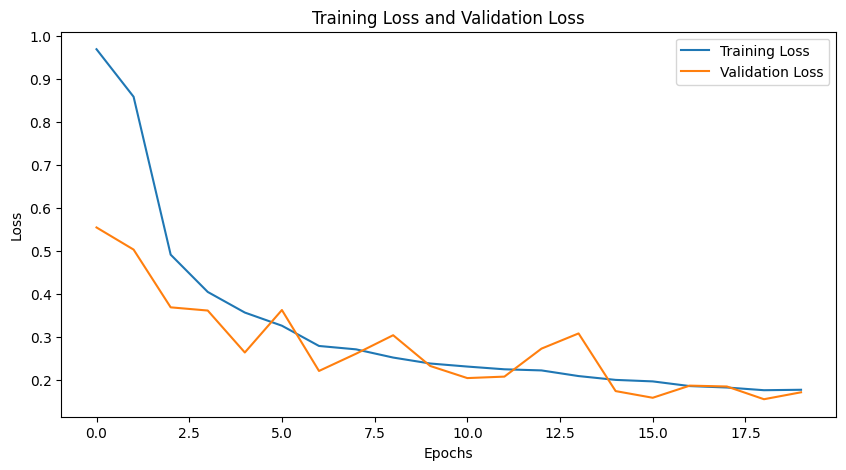

In [ ]:
#plot loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.title("Training Loss and Validation Loss")
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

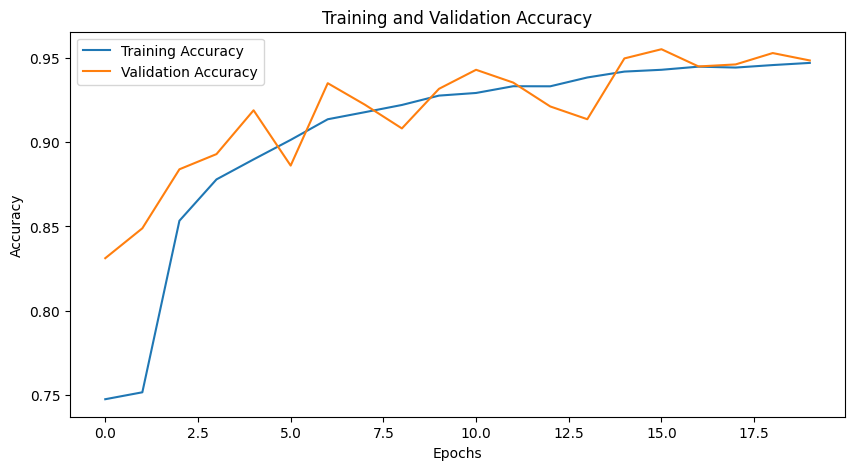

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.title("Training and Validation Accuracy")
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# Testing

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Test function to evaluate classifier and generate confusion matrix
def test_classifier(classifier, dataloader):
    all_preds = []
    all_targets = []

    classifier.eval()
    with torch.no_grad():
        for points, targets in dataloader:
            points = points.transpose(2, 1).to(DEVICE)
            targets = targets.squeeze().to(DEVICE)
            # print(points.shape)
            preds, _, _, _ = classifier(points)

            predicted_class = torch.softmax(preds, dim=1).argmax(dim=1)

            all_preds.extend(predicted_class.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    # Calculate accuracy
    accuracy = np.mean(np.array(all_preds) == np.array(all_targets))

    # Generate confusion matrix
    cm = confusion_matrix(all_targets, all_preds)

    return cm, accuracy

    # # Plot confusion matrix
    # plt.figure(figsize=(8, 6))
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
    # plt.xlabel('Predicted')
    # plt.ylabel('True')
    # plt.title('Confusion Matrix')
    # plt.show()

    # print(f"Overall Accuracy: {accuracy}")

In [ ]:
classifier = PointNetClas(num_points=10000,num_global_ftrs=1024, num_classes=16).to(DEVICE)
classifier.load_state_dict(torch.load("/content/pointnetclassifier.pth", map_location=DEVICE))

<All keys matched successfully>

In [ ]:
cm,accuracy = test_classifier(classifier, test_dataloader)
print("Test accuracy is: ", accuracy)

Test accuracy is:  0.8472512178148921


In [ ]:
category_map = {
    'Airplane': '02691156',
    'Bag': '02773838',
    'Cap': '02954340',
    'Car': '02958343',
    'Chair': '03001627',
    'Earphone': '03261776',
    'Guitar': '03467517',
    'Knife': '03624134',
    'Lamp': '03636649',
    'Laptop': '03642806',
    'Motorbike': '03790512',
    'Mug': '03797390',
    'Pistol': '03948459',
    'Rocket': '04099429',
    'Skateboard': '04225987',
    'Table': '04379243'
}

Normalized confusion matrix


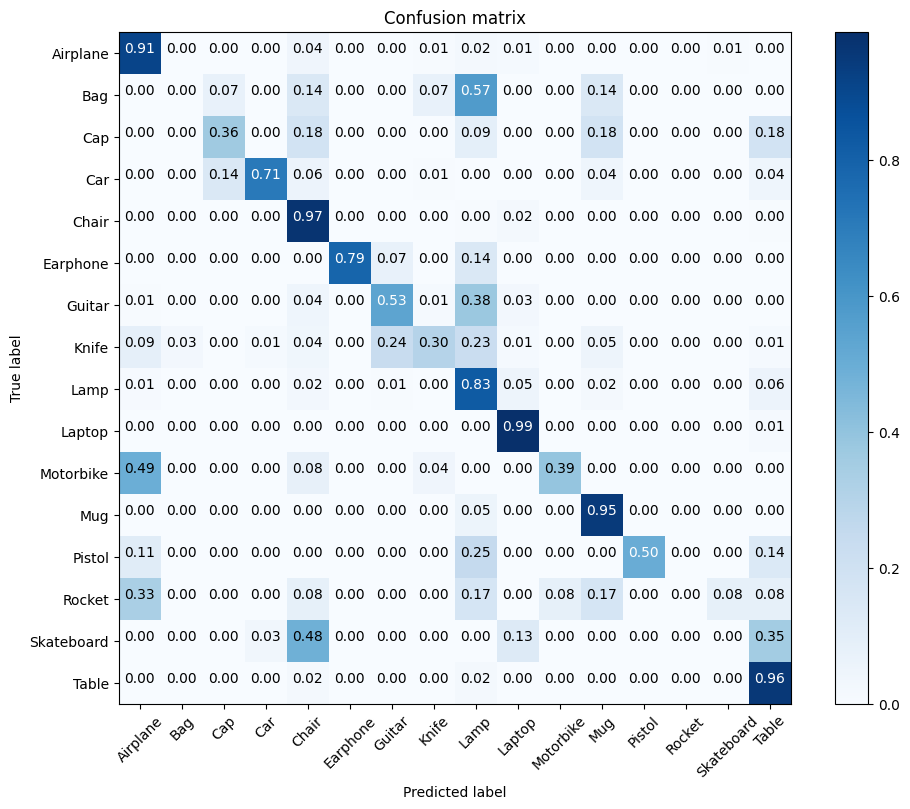

In [ ]:
import matplotlib.pyplot as plt
import itertools

# Function to display confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix
plot_confusion_matrix(cm, classes=category_map.keys(), normalize=True)  # Adjust normalize=True/False as needed
plt.show()